In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score,
    roc_auc_score, roc_curve, make_scorer
)
from sklearn.svm import LinearSVC
from collections import Counter
from tqdm import tqdm

In [2]:
SEED = 4213
random.seed(SEED)
np.random.seed(SEED)

df = pd.read_csv("combine_data_clean.csv")
print(df["source"].value_counts())
print(df["is_sarcastic"].value_counts())

texts = df["text"].astype(str).tolist()
labels = df["is_sarcastic"].astype(int).values

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=SEED, stratify=labels
)

# Fit TF-IDF only on training texts
vectorizer = TfidfVectorizer(
    lowercase=True,
    min_df=3, max_df=0.95,
    ngram_range=(1, 2),
    sublinear_tf=True
)
X_train = vectorizer.fit_transform(X_train_texts)
X_test = vectorizer.transform(X_test_texts)

print(f"TF-IDF shape (train): {X_train.shape}, (test): {X_test.shape}")

def report_class_distribution(y, name):
    counter = Counter(y)
    total = sum(counter.values())
    print(f"{name} set:")
    for label, count in sorted(counter.items()):
        print(f"  Class {label}: {count} samples ({count / total * 100:.2f}%)")
    print()

report_class_distribution(y_train, "Train")
report_class_distribution(y_test, "Test")

source
reddit      101082
twitter      66254
headline     55328
Name: count, dtype: int64
is_sarcastic
1    121699
0    100965
Name: count, dtype: int64
TF-IDF shape (train): (178131, 118993), (test): (44533, 118993)
Train set:
  Class 0: 80772 samples (45.34%)
  Class 1: 97359 samples (54.66%)

Test set:
  Class 0: 20193 samples (45.34%)
  Class 1: 24340 samples (54.66%)



In [3]:
param_grid = {"C": [0.0001, 0.001, 0.01, 0.1, 1]}

svc = LinearSVC(
    loss="squared_hinge",
    dual=False,
    random_state=SEED,
    max_iter=10000
)

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("\nBest parameters:", grid_search.best_params_)
print(f"Best mean CV F1 score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters: {'C': 0.1}
Best mean CV F1 score: 0.8048



Test Set Performance:
Accuracy  : 0.7871
F1 Score  : 0.8098
ROC-AUC   : 0.8713

Classification Report:
              precision    recall  f1-score   support

           0     0.7815    0.7363    0.7582     20193
           1     0.7912    0.8292    0.8098     24340

    accuracy                         0.7871     44533
   macro avg     0.7864    0.7828    0.7840     44533
weighted avg     0.7868    0.7871    0.7864     44533

Confusion Matrix:
 [[14868  5325]
 [ 4157 20183]]


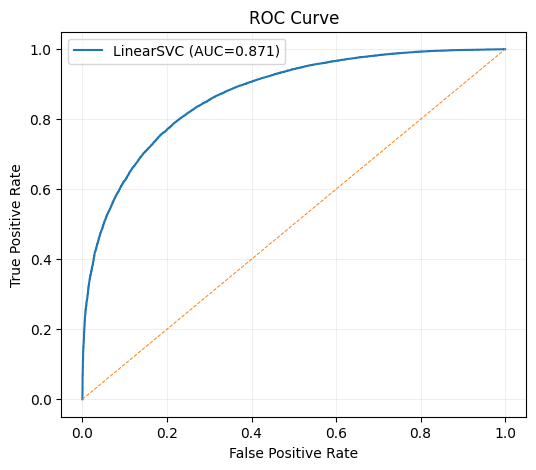

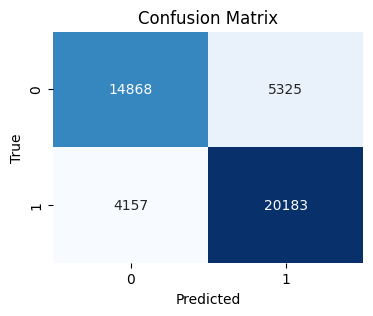

In [4]:
y_test_pred = best_model.predict(X_test)
y_test_scores = best_model.decision_function(X_test)

# Metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_scores)

print("\nTest Set Performance:")
print(f"Accuracy  : {test_acc:.4f}")
print(f"F1 Score  : {test_f1:.4f}")
print(f"ROC-AUC   : {test_auc:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_scores)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LinearSVC (AUC={test_auc:.3f})")
plt.plot([0,1],[0,1],'--', linewidth=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()